<a href="https://colab.research.google.com/github/kcms2ll/AI-Study/blob/main/ETest/src/vanishing_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/rabbit_challenge/DNN_code')
sys.path.append('/content/drive/MyDrive/rabbit_challenge/DNN_code/lesson_2')

import numpy as np
import matplotlib.pyplot as plt
from common import functions

import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from multi_layer_net import MultiLayerNet
from common import optimizer

# 勾配消失問題

## 活性化関数にシグモイド関数を利用している場合に発生

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.12
                : 10. 正答率(テスト) = 0.0982
Generation: 20. 正答率(トレーニング) = 0.11
                : 20. 正答率(テスト) = 0.0974
Generation: 30. 正答率(トレーニング) = 0.11
                : 30. 正答率(テスト) = 0.1028
Generation: 40. 正答率(トレーニング) = 0.1
                : 40. 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.08
                : 50. 正答率(テスト) = 0.101
Generation: 60. 正答率(トレーニング) = 0.12
                : 60. 正答率(テスト) = 0.0958
Generation: 70. 正答率(トレーニング) = 0.08
                : 70. 正答率(テスト) = 0.0958
Generation: 80. 正答率(トレーニング) = 0.14
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.14
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.1
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.09
                : 110. 正答率(テスト) = 0.1028
Generation: 120. 正答率(トレーニング) = 0.08
                : 120. 正答率(テスト) = 0.098
Generation: 130. 正答率(トレーニング) = 0.13
                : 130. 正答率(テスト) = 0.1135
Generation:

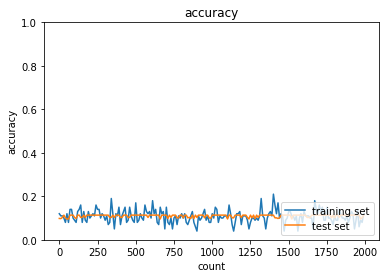

In [3]:
# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

# 重み初期値補正係数
wieght_init = 0.01
#入力層サイズ
input_layer_size = 784
#中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20

#出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100
# 学習率
learning_rate = 0.1
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 
    network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_1_size)
    network['W2'] = wieght_init * np.random.randn(hidden_layer_1_size, hidden_layer_2_size)
    network['W3'] = wieght_init * np.random.randn(hidden_layer_2_size, output_layer_size)

    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    hidden_f = functions.sigmoid

    u1 =  np.dot(x, W1) + b1
    z1 = hidden_f(u1)
    u2 =  np.dot(z1, W2) + b2
    z2 = hidden_f(u2)
    u3 =  np.dot(z2, W3) + b3
    y = functions.softmax(u3)

    return z1, z2, y

# 誤差逆伝播
def backward(x, d, z1, z2, y):
    grad = {}

    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    hidden_d_f = functions.d_sigmoid
    last_d_f = functions.d_softmax_with_loss


    # 出力層でのデルタ
    delta3 = last_d_f(d, y)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 2層でのデルタ
    delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, z2, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]



    z1, z2, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, z2, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)

        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()


上記のように勾配が消失すると、学習が進まないということが起きる

## 1. 活性化関数を変える 
### ReLU 

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.06
                : 10. 正答率(テスト) = 0.1028
Generation: 20. 正答率(トレーニング) = 0.11
                : 20. 正答率(テスト) = 0.1135
Generation: 30. 正答率(トレーニング) = 0.1
                : 30. 正答率(テスト) = 0.1028
Generation: 40. 正答率(トレーニング) = 0.08
                : 40. 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.11
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.09
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.08
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.14
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.14
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.12
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.1
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.08
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.11
                : 130. 正答率(テスト) = 0.1135
Generatio

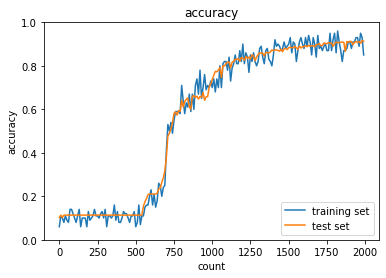

In [4]:
# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

# 重み初期値補正係数
wieght_init = 0.01
#入力層サイズ
input_layer_size = 784
#中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20

#出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100
# 学習率
learning_rate = 0.1
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 

    network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_1_size)
    network['W2'] = wieght_init * np.random.randn(hidden_layer_1_size, hidden_layer_2_size)
    network['W3'] = wieght_init * np.random.randn(hidden_layer_2_size, output_layer_size)
            
    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    ###########  変更箇所  ##############

    hidden_f = functions.relu

    #################################
    
    u1 =  np.dot(x, W1) + b1
    z1 = hidden_f(u1)
    u2 =  np.dot(z1, W2) + b2
    z2 = hidden_f(u2)
    u3 =  np.dot(z2, W3) + b3
    y = functions.softmax(u3)
 
    return z1, z2, y

# 誤差逆伝播
def backward(x, d, z1, z2, y):
    grad = {}
    
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    ###########  変更箇所  ##############
    
    hidden_d_f = functions.d_relu
    
    #################################
    
    
    # 出力層でのデルタ
    delta3 = functions.d_softmax_with_loss(d, y)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 2層でのデルタ
    delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, z2, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    
    z1, z2, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, z2, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

活性化関数をReLUにすることで、勾配消失問題を解消できる。

## 2. 重みの初期値設定を工夫する

In [5]:
class MultiLayerNet_:
    '''
    input_size: 入力層のノード数
    hidden_size_list: 隠れ層のノード数のリスト
    output_size: 出力層のノード数
    activation: 活性化関数
    weight_init_std: 重みの初期化方法
    '''
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu'):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成, sigmoidとreluのみ扱う
        activation_layer = {'sigmoid': layers.Sigmoid, 'relu': layers.Relu}
        self.layers = OrderedDict() # 追加した順番に格納
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = layers.SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, d):
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]

        return self.last_layer.forward(y, d) + weight_decay

    def accuracy(self, x, d):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if d.ndim != 1 : d = np.argmax(d, axis=1)

        accuracy = np.sum(y == d) / float(x.shape[0])
        return accuracy

    def gradient(self, x, d):
        # forward
        self.loss(x, d)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        for idx in range(1, self.hidden_layer_num+2):
            grad['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grad['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grad


### hidden_size_listを変更してみる

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.14
                : 10. 正答率(テスト) = 0.1158
Generation: 20. 正答率(トレーニング) = 0.14
                : 20. 正答率(テスト) = 0.1145
Generation: 30. 正答率(トレーニング) = 0.17
                : 30. 正答率(テスト) = 0.1149
Generation: 40. 正答率(トレーニング) = 0.29
                : 40. 正答率(テスト) = 0.2028
Generation: 50. 正答率(トレーニング) = 0.31
                : 50. 正答率(テスト) = 0.2771
Generation: 60. 正答率(トレーニング) = 0.3
                : 60. 正答率(テスト) = 0.3078
Generation: 70. 正答率(トレーニング) = 0.34
                : 70. 正答率(テスト) = 0.3338
Generation: 80. 正答率(トレーニング) = 0.42
                : 80. 正答率(テスト) = 0.4504
Generation: 90. 正答率(トレーニング) = 0.44
                : 90. 正答率(テスト) = 0.4546
Generation: 100. 正答率(トレーニング) = 0.44
                : 100. 正答率(テスト) = 0.3721
Generation: 110. 正答率(トレーニング) = 0.55
                : 110. 正答率(テスト) = 0.4099
Generation: 120. 正答率(トレーニング) = 0.45
                : 120. 正答率(テスト) = 0.4188
Generation: 130. 正答率(トレーニング) = 0.46
                : 130. 正答率(テスト) = 0.4686
Generati

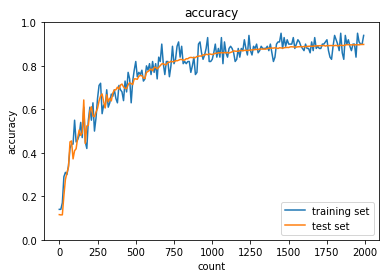

In [6]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet_(input_size=784, hidden_size_list=[50, 40], output_size=10, activation='sigmoid', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

中間層の総数が変わると、学習のスピードも変化する

### sigmoid - He

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.09
                : 10. 正答率(テスト) = 0.1036
Generation: 20. 正答率(トレーニング) = 0.15
                : 20. 正答率(テスト) = 0.1423
Generation: 30. 正答率(トレーニング) = 0.16
                : 30. 正答率(テスト) = 0.1518
Generation: 40. 正答率(トレーニング) = 0.21
                : 40. 正答率(テスト) = 0.2077
Generation: 50. 正答率(トレーニング) = 0.26
                : 50. 正答率(テスト) = 0.2543
Generation: 60. 正答率(トレーニング) = 0.32
                : 60. 正答率(テスト) = 0.3399
Generation: 70. 正答率(トレーニング) = 0.21
                : 70. 正答率(テスト) = 0.2875
Generation: 80. 正答率(トレーニング) = 0.26
                : 80. 正答率(テスト) = 0.2914
Generation: 90. 正答率(トレーニング) = 0.47
                : 90. 正答率(テスト) = 0.3907
Generation: 100. 正答率(トレーニング) = 0.58
                : 100. 正答率(テスト) = 0.5093
Generation: 110. 正答率(トレーニング) = 0.41
                : 110. 正答率(テスト) = 0.4945
Generation: 120. 正答率(トレーニング) = 0.55
                : 120. 正答率(テスト) = 0.5358
Generation: 130. 正答率(トレーニング) = 0.6
                : 130. 正答率(テスト) = 0.5738
Generati

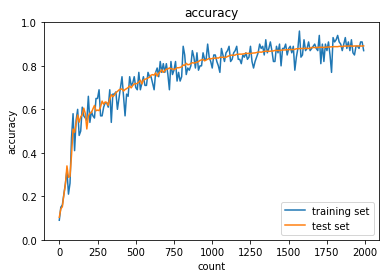

In [7]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet_(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### ReLU - Xavier

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.24
                : 10. 正答率(テスト) = 0.315
Generation: 20. 正答率(トレーニング) = 0.49
                : 20. 正答率(テスト) = 0.4029
Generation: 30. 正答率(トレーニング) = 0.52
                : 30. 正答率(テスト) = 0.5005
Generation: 40. 正答率(トレーニング) = 0.67
                : 40. 正答率(テスト) = 0.6259
Generation: 50. 正答率(トレーニング) = 0.76
                : 50. 正答率(テスト) = 0.7174
Generation: 60. 正答率(トレーニング) = 0.81
                : 60. 正答率(テスト) = 0.7662
Generation: 70. 正答率(トレーニング) = 0.84
                : 70. 正答率(テスト) = 0.8304
Generation: 80. 正答率(トレーニング) = 0.85
                : 80. 正答率(テスト) = 0.8441
Generation: 90. 正答率(トレーニング) = 0.83
                : 90. 正答率(テスト) = 0.8429
Generation: 100. 正答率(トレーニング) = 0.91
                : 100. 正答率(テスト) = 0.8673
Generation: 110. 正答率(トレーニング) = 0.92
                : 110. 正答率(テスト) = 0.8566
Generation: 120. 正答率(トレーニング) = 0.81
                : 120. 正答率(テスト) = 0.8044
Generation: 130. 正答率(トレーニング) = 0.9
                : 130. 正答率(テスト) = 0.8669
Generatio

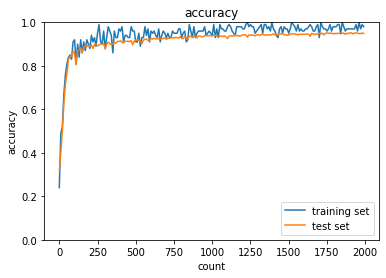

In [8]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet_(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## 3. バッチ正則化

In [9]:
# バッチ正則化 layer
class BatchNormalization:
    '''
    gamma: スケール係数
    beta: オフセット
    momentum: 慣性
    running_mean: テスト時に使用する平均
    running_var: テスト時に使用する分散
    '''
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None

        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward時に使用する中間データ
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0) # 平均
            xc = x - mu # xをセンタリング
            var = np.mean(xc**2, axis=0) # 分散
            std = np.sqrt(var + 10e-7) # スケーリング
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu # 平均値の加重平均
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var #分散値の加重平均
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        
        return out

    def backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.04
                : 10. 正答率(テスト) = 0.1376
Generation: 20. 正答率(トレーニング) = 0.24
                : 20. 正答率(テスト) = 0.2027
Generation: 30. 正答率(トレーニング) = 0.25
                : 30. 正答率(テスト) = 0.2813
Generation: 40. 正答率(トレーニング) = 0.35
                : 40. 正答率(テスト) = 0.3319
Generation: 50. 正答率(トレーニング) = 0.38
                : 50. 正答率(テスト) = 0.3685
Generation: 60. 正答率(トレーニング) = 0.34
                : 60. 正答率(テスト) = 0.3969
Generation: 70. 正答率(トレーニング) = 0.44
                : 70. 正答率(テスト) = 0.4196
Generation: 80. 正答率(トレーニング) = 0.42
                : 80. 正答率(テスト) = 0.4471
Generation: 90. 正答率(トレーニング) = 0.44
                : 90. 正答率(テスト) = 0.4762
Generation: 100. 正答率(トレーニング) = 0.55
                : 100. 正答率(テスト) = 0.504
Generation: 110. 正答率(トレーニング) = 0.5
                : 110. 正答率(テスト) = 0.5202
Generation: 120. 正答率(トレーニング) = 0.47
                : 120. 正答率(テスト) = 0.5392
Generation: 130. 正答率(トレーニング) = 0.52
                : 130. 正答率(テスト) = 0.5589
Generatio

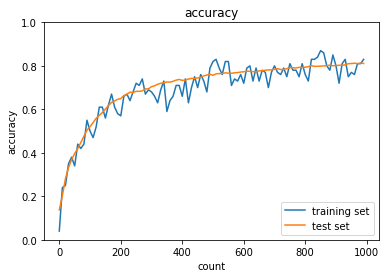

In [10]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")


# batch_normalizationの設定 =======================
use_batchnorm = True
# use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='sigmoid', weight_init_std='Xavier', use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)        
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
                

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### activation:sigmoid, weight_init_std:Xavier



データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.14
                : 10. 正答率(テスト) = 0.0948
Generation: 20. 正答率(トレーニング) = 0.15
                : 20. 正答率(テスト) = 0.1336
Generation: 30. 正答率(トレーニング) = 0.16
                : 30. 正答率(テスト) = 0.1732
Generation: 40. 正答率(トレーニング) = 0.18
                : 40. 正答率(テスト) = 0.2111
Generation: 50. 正答率(トレーニング) = 0.27
                : 50. 正答率(テスト) = 0.2399
Generation: 60. 正答率(トレーニング) = 0.2
                : 60. 正答率(テスト) = 0.2605
Generation: 70. 正答率(トレーニング) = 0.19
                : 70. 正答率(テスト) = 0.2821
Generation: 80. 正答率(トレーニング) = 0.26
                : 80. 正答率(テスト) = 0.2974
Generation: 90. 正答率(トレーニング) = 0.33
                : 90. 正答率(テスト) = 0.3123
Generation: 100. 正答率(トレーニング) = 0.3
                : 100. 正答率(テスト) = 0.3367
Generation: 110. 正答率(トレーニング) = 0.31
                : 110. 正答率(テスト) = 0.3641
Generation: 120. 正答率(トレーニング) = 0.46
                : 120. 正答率(テスト) = 0.389
Generation: 130. 正答率(トレーニング) = 0.38
                : 130. 正答率(テスト) = 0.4146
Generation

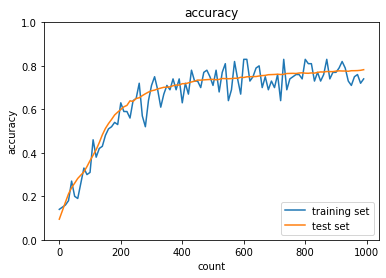

In [11]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")


# batch_normalizationの設定 =======================
use_batchnorm = True
# use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='sigmoid', weight_init_std='Xavier', use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)        
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
                

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### activation:sigmoid, weight_init_std:Xavier

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.49
                : 10. 正答率(テスト) = 0.4008
Generation: 20. 正答率(トレーニング) = 0.43
                : 20. 正答率(テスト) = 0.4834
Generation: 30. 正答率(トレーニング) = 0.53
                : 30. 正答率(テスト) = 0.5935
Generation: 40. 正答率(トレーニング) = 0.75
                : 40. 正答率(テスト) = 0.6883
Generation: 50. 正答率(トレーニング) = 0.66
                : 50. 正答率(テスト) = 0.7395
Generation: 60. 正答率(トレーニング) = 0.81
                : 60. 正答率(テスト) = 0.8243
Generation: 70. 正答率(トレーニング) = 0.85
                : 70. 正答率(テスト) = 0.8206
Generation: 80. 正答率(トレーニング) = 0.78
                : 80. 正答率(テスト) = 0.8377
Generation: 90. 正答率(トレーニング) = 0.89
                : 90. 正答率(テスト) = 0.8548
Generation: 100. 正答率(トレーニング) = 0.91
                : 100. 正答率(テスト) = 0.8807
Generation: 110. 正答率(トレーニング) = 0.83
                : 110. 正答率(テスト) = 0.8766
Generation: 120. 正答率(トレーニング) = 0.82
                : 120. 正答率(テスト) = 0.8938
Generation: 130. 正答率(トレーニング) = 0.92
                : 130. 正答率(テスト) = 0.8934
Generat

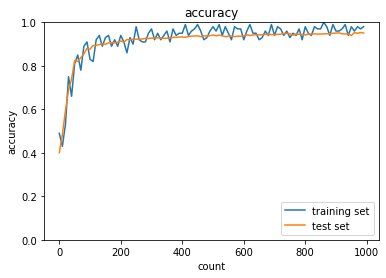

In [12]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 =======================
# use_batchnorm = True
use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std='Xavier',
                       use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    if i == 0:
        m = {}
        v = {}
    learning_rate_t  = learning_rate * np.sqrt(1.0 - beta2 ** (i + 1)) / (1.0 - beta1 ** (i + 1))    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        if i == 0:
            m[key] = np.zeros_like(network.params[key])
            v[key] = np.zeros_like(network.params[key])
            
        m[key] += (1 - beta1) * (grad[key] - m[key])
        v[key] += (1 - beta2) * (grad[key] ** 2 - v[key])            
        network.params[key] -= learning_rate_t * m[key] / (np.sqrt(v[key]) + 1e-7)                
        
        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)        
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
                

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### activation:sigmoid, weight_init_std:0.01

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.14
                : 10. 正答率(テスト) = 0.1135
Generation: 20. 正答率(トレーニング) = 0.09
                : 20. 正答率(テスト) = 0.1135
Generation: 30. 正答率(トレーニング) = 0.13
                : 30. 正答率(テスト) = 0.1135
Generation: 40. 正答率(トレーニング) = 0.07
                : 40. 正答率(テスト) = 0.101
Generation: 50. 正答率(トレーニング) = 0.12
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.09
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.07
                : 70. 正答率(テスト) = 0.1028
Generation: 80. 正答率(トレーニング) = 0.08
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.12
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.07
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.16
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.14
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.07
                : 130. 正答率(テスト) = 0.1135
Generati

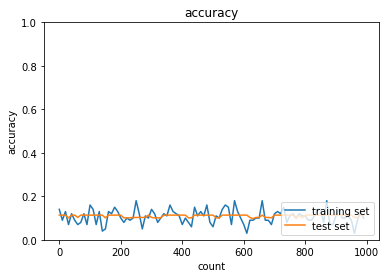

In [13]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 ================================
# use_batchnorm = True
use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01,
                       use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
# 慣性
momentum = 0.9

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    if i == 0:
        v = {}
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        if i == 0:
            v[key] = np.zeros_like(network.params[key])
        v[key] = momentum * v[key] - learning_rate * grad[key]
        network.params[key] += v[key]

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()